In [ ]:
# Geometric distance L2norm Regression for Homography

In [1211]:
import numpy as np

In [1212]:
# Data init 
M = 4  # number of data
N = 3  # features number
data_x = np.random.rand(N,M)*1000
data_x = data_x
data_x[2,:] = 1
t_m = np.random.rand(N,N)
t_m[2,2] = 1
data_y = np.dot(t_m,data_x.copy().astype(float))

In [1213]:
data_x

array([[825.11177597,  76.97138931, 188.78344314,  96.54784501],
       [939.91483525, 198.49137721, 390.13632387, 500.63299411],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [1214]:
t_m = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [1215]:
data_y = np.dot(t_m, data_x.copy().astype(float))
print(data_y)

[[1.16565676e+03 5.11972073e+02 6.16313142e+02 5.52321553e+02]
 [8.56269585e+02 2.45557312e+02 4.14305348e+02 5.32520520e+02]
 [8.42473307e-01 9.87088321e-01 9.66776098e-01 9.87854574e-01]]


In [1302]:
DBG = 0
DBG_LOSS = 0
def DEBUG(*args):
    if DBG: print(*args)

def DEBUGLOSS(*args):
    if DBG_LOSS: print(*args)

In [1303]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [1304]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm', 'update_steps', 'dim','data_m',
                'solver', 'loss_func')
    LOSSFUNCS = {'L2norm':0, 'L1norm':1}
    SOLVERS = {'Grad':0,'Adam':1}

    def __init__(self, var=None, dim=None, iter=500, decay_rate=0.9, norm=1, update_steps=100, data_m=0,
                solver='Grad', loss_func='L2norm'):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.update_steps=update_steps
        self.norm = norm
        self.data_m = data_m
        self.solver = solver
        self.loss_func = loss_func

    def process(self, x, y, method=0):
        if method == 0:
            return x.copy(), y.copy()
        elif method == 1:
            n, m = x.shape
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = x.copy() / self.x_std
            _y = y.copy() / self.x_std
            _x[-1,:] = x[-1,:]
            _y[-1,:] = y[-1,:]
            return _x, _y
        elif method == 2:
            self.x_mean = np.mean(x,axis=1, keepdims=1)
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = (x.copy() - self.x_mean)/self.x_std
            _y = (y.copy() - self.x_mean)/self.x_std
            return _x, _y
        return x.copy(), y.copy()
    
    def pred(W,x):
        return np.dot(W, x)
    
    def computeLoss(self, res):
        n, m = self.dim
        p, q = self.var.val.shape
        if self.loss_func == 'L2norm':
            loss = np.sum(res * res) / (2 * m * n)
        if self.norm > 0:
            loss += (np.sum(self.var.val ** 2) - 1) / (2 * p * q) * self.norm 
        return loss
    
    def lrPolicy(self, iteration, lr):
        if (iteration+1) % self.update_steps == 0:
            lr *= self.decay_rate
        return lr

    def lossDiff(self, pred, y):
        res = (pred - y)
        if self.loss_weights is not None:
            res *= self.loss_weights
        return res

    def computeGradient(self, res, _x, *args):
        n, m = self.dim
        if self.loss_func == 'L2norm':
            tV = np.dot(res, _x.T) / m
        if self.norm > 0:
            tV += self.var.val * self.norm 
        return tV
    
    def computeSolver(self, lr, tV):
        if self.solver == 'Grad':
            dV = lr * tV
        return dV

    def updateWeight(self, dV_masked):
        if self.var.trainable:
            self.var.val -= dV_masked

    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[1] == x.shape[0], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[0] == y.shape[0], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        n, m = self.dim = x.shape
        p, q = self.var.val.shape
        print('processing data')
        _x, _y = self.process(x, y, self.data_m)
        print('output:', _x[:,0], _y[:,0])
        dv_hist = []
        lr= self.lr

        for i in range(self.iter):
            # update policy
            lr = self.lrPolicy(i, lr)

            pred = Regression.pred(self.var.val, _x)
            DEBUG('pred',pred[:,0])

            res = self.lossDiff(pred,y)
            DEBUG('res',res[0,:], '\ntv', np.dot(res, _x.T)[0,:])

            loss = self.computeLoss(res)
            self.j_hist[i,0] = loss

            if (loss < self.err_th):
                return self.var.val
            
            # Gradient
            tV = self.computeGradient(res, _x, m)
            dV = self.computeSolver(lr, tV)

            dv_hist.append(dV[0,0])

            # Update variable
            self.updateWeight(dV * self.var.train_mask)
            DEBUG('dv',dV[0,:],'val',self.var.val[0,:])
            DEBUGLOSS('==============',i,'============', 'loss',loss, lr)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [1305]:
var  = Variables(dim=(N,N))
# var.val[:,-1] = 200
var.val[-1,-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=1000, update_steps=400, data_m=0)
reg.err_th = 1e-10
#reg.lr = 0.000002
reg.lr = np.ones((N,N)) * 0.0000035
reg.lr[:,2] = 0.275
reg.norm = 0
reg.loss_weights = np.array([[1,1,1]]).T

In [1306]:
x_mean = np.mean(data_x, axis=1, keepdims=1)
x_mean[2,0] = 0
_data_x = (data_x) / np.array([[100,100,100]]).T
_data_y = (data_y) / np.array([[100,100,100]]).T

In [1307]:
dv_hist = reg.fit(data_x, data_y)

processing data
output: [825.11177597 939.91483525   1.        ] [1.16565676e+03 8.56269585e+02 8.42473307e-01]
iter Done! Final loss: 6.235712530023916e-09


In [1308]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [1309]:
reg.var.val

array([[ 7.92270906e-01,  8.22135679e-02,  4.34670934e+02],
       [-1.33501667e-01,  9.58413443e-01,  6.55963723e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [1310]:
for idx in range(4):
    test_x = data_x[:,idx]
    test_y = data_y[:,idx]
    pred_y = np.dot(reg.var.val,data_x[:,idx:idx+1])
    print (test_y, pred_y)

[1.16565676e+03 8.56269585e+02 8.42473307e-01] [[1.16565674e+03]
 [8.56269588e+02]
 [8.42473307e-01]]
[511.97207291 245.55731181   0.98708832] [[511.97181023]
 [245.55736778]
 [  0.98708832]]
[616.31314226 414.30534833   0.9667761 ] [[616.31306226]
 [414.30536537]
 [  0.9667761 ]]
[552.32155338 532.52051963   0.98785457] [[552.32180688]
 [532.52046562]
 [  0.98785457]]


In [1176]:
test_y, pred_y

(array([1.24692776e+03, 8.72551513e+02, 8.22174312e-01]),
 array([[836.42794144],
        [270.5636486 ],
        [  0.89838256]]))

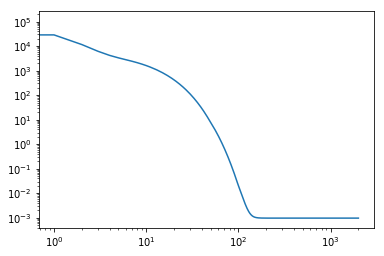

In [1177]:
import matplotlib.pyplot as plt
plt.loglog(reg.j_hist)

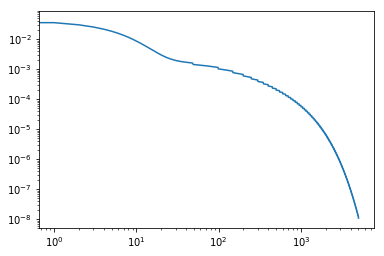

In [513]:
plt.loglog(np.array(dv_hist)*-1)

In [343]:
reg.var.val 

array([[ 1.27959871e+00,  1.27361709e+00,  1.60651565e-01],
       [-5.99621510e-02,  1.13820246e+00,  2.65531557e-02],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [344]:
test_x = (data_x[:,0] - reg.x_mean) / reg.x_std
test_y = (data_y[:,0] - reg.y_mean) / reg.y_std

In [346]:
pred_y = np.dot(reg.var.val, test_x)

ValueError: shapes (3,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

In [420]:
test_y

array([ 1.57175111,  1.17644567, -0.80010062])

In [421]:
pred_y

array([ 1.57144881,  1.17683568, -0.80574305])

In [462]:
t_m

array([[0.82644675, 0.88120926, 0.01278923],
       [0.65749945, 0.44678613, 0.23924547],
       [0.07954453, 0.92108736, 1.        ]])

In [463]:
np.dot(x.T, res)

ValueError: shapes (1,100) and (50,3) not aligned: 100 (dim 1) != 50 (dim 0)

NameError: name 'self' is not defined

In [123]:
for i in range(self.iter):
    pred = np.dot(x, self.var.val)
    # Loss L2norm
    res = pred - y
    loss = 1/(2 * m) *np.sum(res * res) / (n)
    self.j_hist[i,0] = loss
    if (loss < self.err_th):
        return self.var.val
    # Gradient
    dV = (self.ir / m) * np.dot(x.T, res)
    DEBUG('==============',i,'============')
    DEBUG('res:',res[0,...], 'pred:',pred[0,...], 'y:',y[0,...])
    DEBUG('loss:',loss, 'dV:',dV[0,:], 'x:',x.T.shape, 'res:',res.shape)
    # Update variable
    if self.var.trainable:
        self.var.val -= (dV * self.var.train_mask)

array([[0.40377134, 0.51165326, 0.11446054],
       [0.14409324, 0.02794739, 0.74226507],
       [0.65643921, 0.66324733, 1.        ]])

In [480]:
def compute_cost(X, y, params):
    n_samples = len(y)
    h = X @ params
    return (1/(2*n_samples))*np.sum((h-y)**2)
def gradient_descent(X, y, params, learning_rate, n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))

    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X, y, params)

    return (J_history, params)

In [481]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [482]:
dataset = load_boston()

X = dataset.data
y = dataset.target[:,np.newaxis]

print("Total samples in our dataset is: {}".format(X.shape[0]))


Total samples in our dataset is: 506


In [229]:
n_samples = len(y)

mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X-mu) / sigma

X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

Initial cost is:  296.0734584980237 

Optimal parameters are: 
 [[22.53279993]
 [-0.83980839]
 [ 0.92612237]
 [-0.17541988]
 [ 0.72676226]
 [-1.82369448]
 [ 2.78447498]
 [-0.05650494]
 [-2.96695543]
 [ 1.80785186]
 [-1.1802415 ]
 [-1.99990382]
 [ 0.85595908]
 [-3.69524414]] 

Final cost is:  [11.00713381]


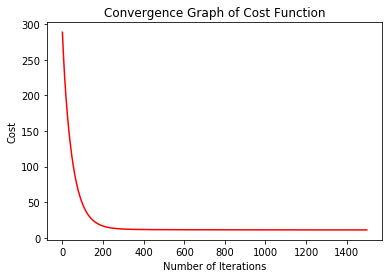

In [230]:
n_iters = 1500
learning_rate = 0.01

initial_cost = compute_cost(X, y, params)

print("Initial cost is: ", initial_cost, "\n")

(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)

print("Optimal parameters are: \n", optimal_params, "\n")

print("Final cost is: ", J_history[-1])

plt.plot(range(len(J_history)), J_history, 'r')

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

In [278]:
class LinearRegression():
    def __init__(self, X, y, alpha=0.03, n_iter=1500):

        self.alpha = alpha
        self.n_iter = n_iter
        self.n_samples = len(y)
        self.n_features = np.size(X, 1)
        self.X = np.hstack((np.ones(
            (self.n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))
        self.y = y[:, np.newaxis]
        self.params = np.zeros((self.n_features + 1, 1))
        self.coef_ = None
        self.intercept_ = None
    def fit(self):

        for i in range(self.n_iter):
            self.params = self.params - (self.alpha/self.n_samples) * \
            self.X.T @ (self.X @ self.params - self.y)

        self.intercept_ = self.params[0]
        self.coef_ = self.params[1:]

        return self

    def score(self, X=None, y=None):

        if X is None:
            X = self.X
        else:
            n_samples = np.size(X, 0)
            X = np.hstack((np.ones(
                (n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))

        if y is None:
            y = self.y
        else:
            y = y[:, np.newaxis]

        y_pred = X @ self.params
        score = 1 - (((y - y_pred)**2).sum() / ((y - y.mean())**2).sum())

        return score

    def predict(self, X):
        n_samples = np.size(X, 0)
        y = np.hstack((np.ones((n_samples, 1)), (X-np.mean(X, 0)) \
                            / np.std(X, 0))) @ self.params
        return y

    def get_params(self):

        return self.params

In [296]:
a = 2.71
b = -2
N = 100
x = np.linspace(0, 10, N)
x = np.expand_dims(x,1)
y = a *x + b + np.random.rand(N,1) / 0.01


In [298]:
lr = LinearRegression(x,y)
lr.fit()

In [16]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [64]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
        
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                invH = np.linalg.inv(self.var.val)
                reproj = np.dot(pred, invH)
                res_re = (reproj - _x) * self.loss_weights
                loss = np.sum(res * res) / (2 * m * n) + np.sum(res_re * res_re) / (2 * m * n)
            elif method == 'LMS':
                loss = np.sum(np.median(res * res, axis=0)) / (2 * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                # https://math.stackexchange.com/questions/190424/how-to-evaluate-the-derivatives-of-matrix-inverse
                tV = np.dot(_x.T, res) / m
                dH = -np.dot(np.dot(invH, self.var.val.T), invH)
                dR = np.dot(pred, dH)
                tV += (np.dot(dR.T, res_re) / m)
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            elif method == 'LMS':
                dV = (lr) # working on
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [155]:
rand = np.random.rand(N,N)
var  = Variables(val=rand,dim=(N,N))
#var  = Variables(dim=(N,N))
var.val[N-1,N-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=1000)
reg.err_th = 1e-10
#reg.lr = 0.000001
#reg.lr = np.ones((N,N)) * 0.01
#reg.lr[-1,:] = 0.0001
reg.lr = 0.1
reg.norm = 1e-8
reg.loss_weights = np.array([[1,1,1]])

In [156]:
dv_hist = reg.fit(data_x, data_y)

processing data
============== 0 ============ loss 116014.94453889747 0.09000000000000001
============== 1 ============ loss 22144.163619434694 0.09000000000000001
============== 2 ============ loss 6089.0714430236585 0.09000000000000001
============== 3 ============ loss 3273.3673188490893 0.09000000000000001
============== 4 ============ loss 2712.7321334867115 0.09000000000000001
============== 5 ============ loss 2538.658798665922 0.09000000000000001
============== 6 ============ loss 2433.211939650282 0.09000000000000001
============== 7 ============ loss 2342.2069540665484 0.09000000000000001
============== 8 ============ loss 2256.326148113136 0.09000000000000001
============== 9 ============ loss 2173.887221394699 0.09000000000000001
============== 10 ============ loss 2094.5101826155715 0.09000000000000001
============== 11 ============ loss 2018.0399845150655 0.09000000000000001
============== 12 ============ loss 1944.3631428361227 0.09000000000000001
============== 13 =====

============== 118 ============ loss 37.726046908211856 0.09000000000000001
============== 119 ============ loss 36.34874191500853 0.09000000000000001
============== 120 ============ loss 35.021720929076224 0.09000000000000001
============== 121 ============ loss 33.74314813274945 0.09000000000000001
============== 122 ============ loss 32.511254732179815 0.09000000000000001
============== 123 ============ loss 31.32433651036591 0.09000000000000001
============== 124 ============ loss 30.180751469519826 0.09000000000000001
============== 125 ============ loss 29.078917559506188 0.09000000000000001
============== 126 ============ loss 28.01731048921618 0.09000000000000001
============== 127 ============ loss 26.99446161784433 0.09000000000000001
============== 128 ============ loss 26.008955923153707 0.09000000000000001
============== 129 ============ loss 25.05943004391651 0.09000000000000001
============== 130 ============ loss 24.144570393824324 0.09000000000000001
============== 131

============== 262 ============ loss 0.22570251284208398 0.08100000000000002
============== 263 ============ loss 0.21831116516551327 0.08100000000000002
============== 264 ============ loss 0.21116291011560792 0.08100000000000002
============== 265 ============ loss 0.20424975268781856 0.08100000000000002
============== 266 ============ loss 0.19756396082259015 0.08100000000000002
============== 267 ============ loss 0.19109805675757918 0.08100000000000002
============== 268 ============ loss 0.18484480866408198 0.08100000000000002
============== 269 ============ loss 0.17879722255867905 0.08100000000000002
============== 270 ============ loss 0.17294853448075748 0.08100000000000002
============== 271 ============ loss 0.16729220292741193 0.08100000000000002
============== 272 ============ loss 0.16182190153712836 0.08100000000000002
============== 273 ============ loss 0.15653151201398585 0.08100000000000002
============== 274 ============ loss 0.1514151172847922 0.08100000000000002


============== 394 ============ loss 0.003685811862059613 0.08100000000000002
============== 395 ============ loss 0.0035963618601692797 0.08100000000000002
============== 396 ============ loss 0.003509853897663259 0.08100000000000002
============== 397 ============ loss 0.0034261912124012367 0.08100000000000002
============== 398 ============ loss 0.0033452802246455946 0.08100000000000002
============== 399 ============ loss 0.003267030432427864 0.08100000000000002
============== 400 ============ loss 0.0031913543102859085 0.07290000000000002
============== 401 ============ loss 0.0031254308476047193 0.07290000000000002
============== 402 ============ loss 0.003061460446536621 0.07290000000000002
============== 403 ============ loss 0.0029993852469360326 0.07290000000000002
============== 404 ============ loss 0.002939149102754309 0.07290000000000002
============== 405 ============ loss 0.0028806975312610427 0.07290000000000002
============== 406 ============ loss 0.002823977663785937

============== 532 ============ loss 0.0010082589386043977 0.07290000000000002
============== 533 ============ loss 0.0010070150477054201 0.07290000000000002
============== 534 ============ loss 0.0010058080217918597 0.07290000000000002
============== 535 ============ loss 0.0010046367685281061 0.07290000000000002
============== 536 ============ loss 0.0010035002279409756 0.07290000000000002
============== 537 ============ loss 0.001002397371463358 0.07290000000000002
============== 538 ============ loss 0.0010013272010006076 0.07290000000000002
============== 539 ============ loss 0.0010002887480309516 0.07290000000000002
============== 540 ============ loss 0.0009992810727265818 0.07290000000000002
============== 541 ============ loss 0.0009983032631053898 0.07290000000000002
============== 542 ============ loss 0.0009973544342055227 0.07290000000000002
============== 543 ============ loss 0.0009964337272843676 0.07290000000000002
============== 544 ============ loss 0.00099554030904

============== 688 ============ loss 0.0009668006797206002 0.06561000000000002
============== 689 ============ loss 0.0009667873536254029 0.06561000000000002
============== 690 ============ loss 0.0009667743844593516 0.06561000000000002
============== 691 ============ loss 0.0009667617626805677 0.06561000000000002
============== 692 ============ loss 0.0009667494790019137 0.06561000000000002
============== 693 ============ loss 0.0009667375243844198 0.06561000000000002
============== 694 ============ loss 0.0009667258900304918 0.06561000000000002
============== 695 ============ loss 0.0009667145673774964 0.06561000000000002
============== 696 ============ loss 0.0009667035480915269 0.06561000000000002
============== 697 ============ loss 0.000966692824061232 0.06561000000000002
============== 698 ============ loss 0.0009666823873919451 0.06561000000000002
============== 699 ============ loss 0.0009666722303998806 0.06561000000000002
============== 700 ============ loss 0.00096666234560

============== 868 ============ loss 0.0009663089577844541 0.05904900000000002
============== 869 ============ loss 0.0009663088547838579 0.05904900000000002
============== 870 ============ loss 0.0009663087543644181 0.05904900000000002
============== 871 ============ loss 0.0009663086564628259 0.05904900000000002
============== 872 ============ loss 0.0009663085610173104 0.05904900000000002
============== 873 ============ loss 0.0009663084679675972 0.05904900000000002
============== 874 ============ loss 0.0009663083772548809 0.05904900000000002
============== 875 ============ loss 0.0009663082888217737 0.05904900000000002
============== 876 ============ loss 0.0009663082026122944 0.05904900000000002
============== 877 ============ loss 0.0009663081185718121 0.05904900000000002
============== 878 ============ loss 0.0009663080366470291 0.05904900000000002
============== 879 ============ loss 0.0009663079567859404 0.05904900000000002
============== 880 ============ loss 0.0009663078789

In [153]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [158]:
reg.var.val

array([[ 7.90900075e-01,  8.06359397e-02,  4.34671372e+02],
       [-1.33281047e-01,  9.58667338e-01,  6.55963190e+01],
       [ 6.01986564e-01,  6.91658939e-01,  1.00000000e+00]])

In [160]:
for idx in range(4):
    test_x = data_x[idx]
    test_y = data_y[idx]
    pred_y = np.dot(data_x[idx], reg.var.val)
    print (data_x[idx], test_y, pred_y)

[366 632   1] [   205.59822578    635.80706082 200547.58662   ] [   205.83779247    636.08217029 200547.59589302]
[691 937   1] [   422.36864044    954.84210175 361822.66579   ] [   422.22959761    954.68238868 361822.66920104]
[386  74   1] [2.95937776e+02 1.02656381e+02 1.72638300e+05] [2.96026618e+02 1.02758515e+02 1.72638277e+05]
[570 609   1] [   370.2923331    630.5347429 287711.846716 ] [   370.24687188    630.48255322 287711.84051069]


In [150]:
data_x

array([[366, 632,   1],
       [691, 937,   1],
       [386,  74,   1],
       [570, 609,   1]])

In [ ]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
    
    
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                loss = np.sum(res * res) / (2 * m * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                tV = np.dot(_x.T, res) / m
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [990]:
res = np.array([[188.51387797, 188.25674871, 190.24676645, 185.97885747],
 [194.12135314, 191.07547677, 189.01739573, 194.65284295],
 [ -1.82874661,   0.91050942,  -1.23402567,   2.45709586]]) 
xT = np.array([[-2.50696386, -5.9552604,   1.        ],
 [ 0.96999609,  2.84768042,  1.        ],
 [-3.60295508, -0.58000537,  1.        ],
 [ 5.13992285,  3.68758535,  1.        ]] )
tv = np.array([[-1.95227435e+01, -1.10854111e+01,  7.52996251e+02],
 [ 1.81666577e+01, -3.75344571e+00,  7.68867069e+02],
 [ 2.25432145e+01,  2.32599944e+01,  3.04832992e-01]])

In [994]:
(188.51387797 * -2.50696386)  + (188.25674871 * 0.96999609) +  (190.24676645*-3.60295508) + (185.97885747 * 5.13992285)

-19.52274352208258

In [993]:
np.dot(res[0,:],xT[:,0])

-19.52274352208258

In [991]:
res @ xT

array([[-1.95227435e+01, -1.10854110e+01,  7.52996251e+02],
       [ 1.81666577e+01, -3.75344576e+00,  7.68867069e+02],
       [ 2.25432144e+01,  2.32599943e+01,  3.04833000e-01]])

In [978]:
tv [[-2.04379374e-02  1.77674701e-02  1.24713524e+02]
 [ 2.77237708e-02 -2.41013200e-02  1.27342097e+02]
 [ 4.63450171e-03 -4.02894719e-03  3.04832992e-01]]
dv [-1.02189687e-04  8.88373504e-05  6.23567619e-01] val [ 0.79079653  0.08349476 34.54371102]

array([[-1.95227435e+01, -1.10854111e+01,  7.52996251e+02],
       [ 1.81666577e+01, -3.75344571e+00,  7.68867069e+02],
       [ 2.25432145e+01,  2.32599944e+01,  3.04832992e-01]])

In [998]:
1.24713524e+02 * 0.02 / 4

0.6235676200000001